In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

In [2]:
"""
    The following ResNet implementations are the official version of Pytorch library
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
"""

import torch
import torch.nn as nn

try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError(
                'BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError(
                "Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

def resnet_18_cifar():
    r"""
        Modify the resnet 18 network in order to run on cifar-10 dataset

        To enhance the accuracy, the (kernel_size, stride, padding) of conv1 is modified to (3, 1, 1)
        referenced by <https://github.com/akamaster/pytorch_resnet_cifar10>  
    """
    model = ResNet(block=BasicBlock, layers=[2, 2, 2, 2], num_classes=10)

    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1,
                            bias=False)

    return model


In [3]:
# load the data
train_transform = transforms.Compose(
    [
     transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))])

test_transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))])

ds = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)


test_ds = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

# split the training set and validation set
torch.manual_seed(50)
test_size = len(test_ds)
val_size = 5000
train_size = len(ds) - val_size
batch_size = 256

train_ds, val_ds = random_split(ds, [train_size, val_size])


train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

classes = ds.classes

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
print(train_size)
print(val_size)
print(test_size)
print(torch.cuda.is_available())

45000
5000
10000
True


In [7]:
import time

def validate(model, criterion, val_loader, use_gpu=False):
  val_size = len(val_loader.dataset)
  val_loss = 0
  correct = 0
  device = torch.device( "cuda:0" if use_gpu else "cpu" )

  with torch.no_grad():
    for i, data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # forward + backward + optimize
        outputs = model(inputs).to(device)
        loss = criterion(outputs, labels)
        
        val_loss += loss * inputs.size(0)
        
        # val accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    val_loss = val_loss/val_size
    val_accuracy = correct/val_size;

  return val_loss, val_accuracy

def get_train_accuracy(model, criterion, train_loader, use_gpu=False):
   train_size = len(train_loader.dataset)
   correct = 0
   device = torch.device( "cuda:0" if use_gpu else "cpu" )
   
   with torch.no_grad():
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # forward + backward + optimize
        outputs = model(inputs).to(device)

        # val accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print(correct)
    return correct/train_size

def train(model, criterion, optimizer, train_loader, val_loader, epoch=128, use_gpu=False):

  train_size = len(train_loader.dataset)
  device = torch.device( "cuda:0" if use_gpu else "cpu" )
  
  history = {
      'train_loss': [], 
      'train_accuracy': [], 
      'val_loss': [], 
      'val_accuracy': []
      } 

  model = model.to(device)

  for epoch in range(epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    
    print(f'------------------------------\n Epoch: {epoch + 1}')
    
    t1 = time.time()
    for  i,data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # as loss.item() return the average batch loss, so convert it to the total loss
        running_loss += loss.item() * inputs.size(0)
           
    t2 = time.time()
    t = t2 - t1

    # save the model
    PATH = f'./model_weights/resnet18-e{epoch + 1}.pth'
    torch.save(model.state_dict(), PATH)

    epoch_train_loss = running_loss/train_size
    epoch_train_accuracy = get_train_accuracy(model, criterion, train_loader, use_gpu)
    epoch_val_loss, epoch_val_accuracy = validate(model, criterion, val_loader, use_gpu)
    print(f'time: {int(t)}sec train_loss: {epoch_train_loss}, train_accuracy: {epoch_train_accuracy}, val_loss: {epoch_val_loss}, val_accuracy: {epoch_val_accuracy}');
  
    history['train_loss'].append(epoch_train_loss)
    history['train_accuracy'].append(epoch_train_accuracy)
    history['val_loss'].append(epoch_val_loss)
    history['val_accuracy'].append(epoch_val_accuracy)
 
  return history

In [8]:
# define a model
model = resnet_18_cifar()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

history = train(model, criterion, optimizer, train_loader, val_loader, 128, torch.cuda.is_available())

------------------------------
 Epoch: 1
19105
time: 23sec train_loss: 1.8287252455393472, train_accuracy: 0.4245555555555556, val_loss: 1.5445795059204102, val_accuracy: 0.4216
------------------------------
 Epoch: 2
23221
time: 23sec train_loss: 1.4356065607706705, train_accuracy: 0.5160222222222223, val_loss: 1.3523989915847778, val_accuracy: 0.5022
------------------------------
 Epoch: 3
25687
time: 23sec train_loss: 1.2760931777318318, train_accuracy: 0.5708222222222222, val_loss: 1.2078591585159302, val_accuracy: 0.561
------------------------------
 Epoch: 4
27259
time: 24sec train_loss: 1.1443666210810344, train_accuracy: 0.6057555555555556, val_loss: 1.1108152866363525, val_accuracy: 0.5946
------------------------------
 Epoch: 5
28395
time: 24sec train_loss: 1.0572382137298584, train_accuracy: 0.631, val_loss: 1.047979474067688, val_accuracy: 0.627
------------------------------
 Epoch: 6
29888
time: 24sec train_loss: 0.9833542873488532, train_accuracy: 0.6641777777777778,

In [10]:
import pickle as pk

with open('./train_params.pkl', 'wb') as f:
  pk.dump({
      'history': history,
      'num_of_epoch': 128,
      'lr': 0.003,
      'momentum': 0.9
  }, f)

In [28]:
with open('./train_params.pkl', 'rb') as f:
  train_params = pk.load(f)

In [29]:
history = train_params['history']
history['val_loss'] = [item.item() for item in train_params['history']['val_loss']]



In [45]:
# run test set
def test(model, criterion, test_loader, use_gpu=False):
  test_size = len(test_loader.dataset)
  device = torch.device( "cuda:0" if use_gpu else "cpu" )
  test_loss = 0.0
  test_accuracy = 0
  correct = 0

  with torch.no_grad():
      for i, data in enumerate(test_loader):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # forward + backward + optimize
          outputs = model(inputs).to(device)
          loss = criterion(outputs, labels)
          
          test_loss += loss * inputs.size(0)
          
          # val accuracy
          _, predicted = torch.max(outputs.data, 1)
          correct += (predicted == labels).sum().item()

      
      test_loss = test_loss/test_size
      test_accuracy = correct/test_size;

  return test_loss, test_accuracy

In [46]:
test_loss, test_accuracy = test(model, criterion, test_loader, True)
history['test_loss'] = test_loss
history['test_accuracy'] = test_accuracy

In [47]:
print(history['test_loss'], history['test_accuracy'] )

tensor(0.7665, device='cuda:0') 0.8299


In [48]:
import pickle as pk

with open('./train_params.pkl', 'wb') as f:
  pk.dump({
      'history': history,
      'num_of_epoch': 128,
      'lr': 0.003,
      'momentum': 0.9
  }, f)

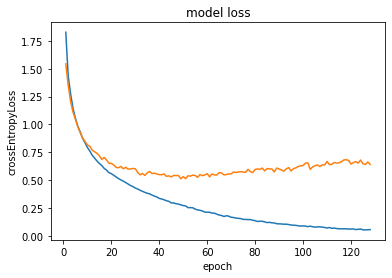

In [57]:
import matplotlib.pyplot as plt
num_of_epoch = range(1, 129)

plt.plot(num_of_epoch, history['train_loss'], label="train_loss")
plt.plot(num_of_epoch, history['val_loss'], label="val_loss")
plt.xlabel('epoch')
plt.ylabel('crossEntropyLoss')
plt.title('model loss')

plt.savefig('./model_loss.jpg')

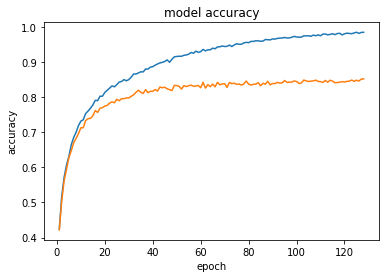

In [58]:
plt.plot(num_of_epoch, history['train_accuracy'], label="train_accuracy")
plt.plot(num_of_epoch, history['val_accuracy'], label="val_accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('model accuracy')
plt.savefig('./model_acc.jpg')